# ADA final exam (Fall 2024)

This exam consists of 2 tasks. The two tasks are independent of each other. You can solve them in any order.

## Task 1: Natural Language Processing (50 pts)
This part of the exam will analyze a real-world negotiation dataset:

Two participants take the role of campsite neighbors and negotiate for Food, Water, and Firewood packages, based on their individual preferences and requirements. This design keeps the task tractable, while still facilitating linguistically rich and personal conversations.

At the end of each negotiation, both negotiators receive an outcome score (`outcome`) reflecting their success in achieving their goals. The dataset is divided into two data frames:

1. `df_negotiations`, with columns:
    - `negotiation_id`: the negotiation identifier
    - `agent`: the agent active in that turn, either `mt_agent_1` or `mt_agent_2` (first and second to interact)
    - `message`: the message sent to the other agent
    - `turn`: the negotiation turn
2. `df_meta`, meta information for each negotiation with the outcome and agent background:
    - `gender`: (male, female, other)
    - `age`: integer
    - `outcome`: integer

We are interested in finding out: what makes a good (/bad) negotiator?

### Part 1: Coding Questions (29 pt)

In [ ]:
import pandas as pd

df_negotiations = pd.read_csv('negotiations.csv')
df_negotiations.head()

In [ ]:
df_meta = pd.read_csv('negotiations_meta.csv')
df_meta.head()

**1.1 (2 pt)**
/Discussion:/ We are interested in analyzing negotiation outcomes by analyzing language usage. In order to use TF-IDF to accomplish this, we will treat all turns from one negotiator in a single negotiation as a "document". Why would this definition of "document" be preferred over the following two alternatives? Give at least one argument per alternative.

- A) Each individual turn is a document
- B) The entire negotiation dialogue of both negotiators is a document

**Grading instruction**: [2 pt]
1. [A] Provides sufficient text length for meaningful TF-IDF statistics
2. [A, B] Controls for individual negotiator
3. [B] Allows for analyses based on meta information like, gender, age, and starting position.
4. Other reasonable answers.

**1.2 (3 pt)**

[A, 1 pt] Use the negotiation dataset to create a new dataframe called `df_document` with the following columns:
- `negotiation_id`
- `agent`
- `document`

Here, document is defined as described in question 1.1. That is: concatonate messages into a single string and split by the special character `"\n"`.

In [ ]:
df_document = (
    df_negotiations
    .groupby(['negotiation_id', 'agent'])['message']
    .apply(lambda messages: '\n'.join(messages))
    .reset_index()
    .rename(columns={'message': 'document'})
)

df_document.head()

**Grading Instruction.** [1pt]
- [1 pt] created `df_document` correctly

[B, 2pt] Next, merge this new dataframe with the `df_meta` dataframe. Print the the size and first five rows of the final dataframe

In [ ]:
df_document_m = pd.merge(df_document, df_meta, on=["negotiation_id", "agent"], how="inner")
print(f"size: {df_document_m.size}")
df_document_m.head()

size: 12336


,negotiation_id,agent,document,age,gender,outcome
0,0,mturk_agent_1,Hello! 🙂 Let's work together on a deal for the...,43,male,19
1,0,mturk_agent_2,Hey! I'd like some more firewood to keep my do...,22,female,18
2,1,mturk_agent_1,I am good. I am pretty excited for the trip th...,24,female,19
3,1,mturk_agent_2,Hello. How are you?\nVery excited. It will be ...,43,female,17
4,2,mturk_agent_1,Hi! How are you?! You excited for your camping...,30,female,14


**Grading Instruction.** [2 pt]
- [1 pt] correct size
- [1 pt] correct merge

**1.3 (7 pt)**
We would like to analyze the difference between "best" and "worst" performers based on `outcome`, top and bottom 10% respectively.

[A, 2 pt] Find the top and bottom 10% thresholds for the `outcome` columns and print them.

In [ ]:
top_10_threshold = df_document_m['outcome'].quantile(0.9)
bottom_10_threshold = df_document_m['outcome'].quantile(0.1)

print(f"best 10% threshold: {top_10_threshold: .2f}")
print(f"worst 10% threshold: {bottom_10_threshold: .2f}")

best 10% threshold:  23.00
worst 10% threshold:  15.50


**Grading Instruction.** [2pt]
- [1 pt] correct threshold bottom 10%
- [1 pt] correct threshold top 10%

[B, 1pt] Create a TF-IDF matrix using the `TfidfVectorizer` form `sklearn`, setting `max_features=100` and `stop_words="english"`. Print the resulting TF-IDF matrix shape.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=100, stop_words="english")
tfidf_matrix = vectorizer.fit_transform(df_document_m['document'])

print(tfidf_matrix.shape)

(2056, 100)


**Grading Instruction.** [1pt]
- [1 pt] correct tfidf matrix and size

[C, 4pt] Use your thresholds and the TF-IDF matrix to print the top 10 terms for each type of negotiatior (i.e., the best and worst performing negotiators from question 1.3.A).

In [ ]:
top_negotiators = df_document_m[df_document_m['outcome'] > top_10_threshold].index
bottom_negotiators = df_document_m[df_document_m['outcome'] < bottom_10_threshold].index

# scores for each term
top_tfidf_scores = tfidf_matrix[top_negotiators].mean(axis=0).A1.argsort()
bottom_tfidf_scores = tfidf_matrix[bottom_negotiators].mean(axis=0).A1.argsort()

all_terms = vectorizer.get_feature_names_out() 
top_10_terms = [all_terms[i] for i in top_tfidf_scores[-10:][::-1]]
bottom_10_terms = [all_terms[i] for i in bottom_tfidf_scores[-10:][::-1]]


print(f"best 10% negotiatiors top 10 terms: {top_10_terms}")
print(f"worst 10% negotiatiors top 10 terms: {bottom_10_terms}")

best 10% negotiatiors top 10 terms: ['firewood', 'food', 'water', 'deal', 'need', 'extra', 'okay', 'want', 'submit', 'packages']
worst 10% negotiatiors top 10 terms: ['food', 'water', 'firewood', 'need', 'deal', 'extra', 'packages', 'like', 'package', 'submit']


**Grading Instruction.** [4pt]
- [2 pt] correct top terms for worst negotiators
- [2 pt] correct top terms for best negotiators

**1.4 (8 pt)**
You never get a second chance at a first impression! Let's investigate if the same goes for negotiations...

[A, 1pt] Create a new df_document that only takes into account the first three (3) turns of each negotiator in a negotiation. Again, merge on the df_meta dataframe and print the resulting size.

In [ ]:
df_document3 = (
    df_negotiations[df_negotiations['turn'] < 3]
    .groupby(['negotiation_id', 'agent'])['message']
    .apply(lambda messages: '\n'.join(messages))
    .reset_index()
    .rename(columns={'message': 'document'})
)

df_document3_m = pd.merge(df_document3, df_meta, on=["negotiation_id", "agent"], how="inner")
print(f'size: {df_document3_m.size}')

size: 12336


**Grading Instruction.** [1pt]
- [1 pt] correctly created the dataframe.

[B, 1pt] Calculate the median negotiation outcome. Then, add a column called success to the df_document dataframe that is 1 if the outcome column is more than the median and 0 otherwise. Print the median outcome.

In [ ]:
median_outcome = df_document3_m['outcome'].median()

df_document3_m['success'] = (df_document3_m['outcome'] > median_outcome).astype(int)

print(f"median outcome: {median_outcome}")

median outcome: 19.0


**Grading Instruction.** [1pt]
- [1 pt] correct median outcome

[C, 2pt] Create a TF-IDF matrix called `X` based on `df_document` using the following settings:

`max_features=100, stop_words="english, ngram_range=(1, 2)`

Additionally, create a variable `y` that corresponds to the success column. Finally, use `sklearn.model_selection.train_test_split` to split your data into a train and test set using parameters `test_size=0.2` and `random_state=99`.

Print the shape of the TF-IDF and the shape of your train and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(max_features=100, stop_words='english', ngram_range=(1, 2))
X = vectorizer.fit_transform(df_document3_m['document'])
y = df_document3_m['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)


print(f"TF-IDF matrix shape: {X.shape}")
print(f"TF-IDF train matrix shape: {X_train.shape}")
print(f"y train shape: {y_train.shape}")

TF-IDF matrix shape: (2056, 100)
TF-IDF train matrix shape: (1644, 100)
y train shape: (1644,)


**Grading Instruction.** [2pt]
- [1 pt] correct tfidf matrix
- [1 pt] correct train shapes

[D, 2pt] Use your prepared data to train a logistic regression model (`sklearn.linear_model.LogisticRegression`). Then, with the trained model predict on the test set and print a classification report (`sklearn.metrics.classification_report`).

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

logistic_model = LogisticRegression(random_state=99)
logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)

report = classification_report(y_test, y_pred, target_names=["success = 0", "success = 1"])
print(report)

              precision    recall  f1-score   support

 success = 0       0.64      0.94      0.76       264
 success = 1       0.27      0.04      0.07       148

    accuracy                           0.62       412
   macro avg       0.45      0.49      0.41       412
weighted avg       0.51      0.62      0.51       412



**Grading Instruction.** [2 pt]
- [1 pt] successfully trained logistic regression model
- [1 pt] printed the classification report

[E, 2pt] Use the weights of your trained model to show which terms mostly strongly correlate with high and low outcomes. Print the best five terms for each.

In [ ]:
weights = logistic_model.coef_[0]

top_positive_indices = weights.argsort()[-5:][::-1]
top_negative_indices = weights.argsort()[:5]

all_terms = vectorizer.get_feature_names_out() 
top_positive_terms = [all_terms[i] for i in top_positive_indices]
top_negative_terms = [all_terms[i] for i in top_negative_indices]

print(f"Top 5 terms for high outcomes: {top_positive_terms}")
print(f"Top 5 terms for low outcomes: {top_negative_terms}")

Top 5 terms for high outcomes: ['water', 'items', 'nice', 'night', 'stay']
Top 5 terms for low outcomes: ['know', 'extra firewood', 'food water', 'today', 'sure']


**Grading Instruction.** [2pt]
- [1 pt] correct top 5 terms for high outcomes
- [1 pt] correct top 5 terms for low outcomes

**1.5 (9 pt)**
You are concerned about potential “confounding” factors for your results in the previous question. Specifically, you would like to investigate the effect of “gender” on the outcomes.

[A, 3pt] Visualize the outcomes stratified by gender using a bar plot with standard deviation around the mean. Make sure you use clear x- and y-axis labels, a title, and a legend.

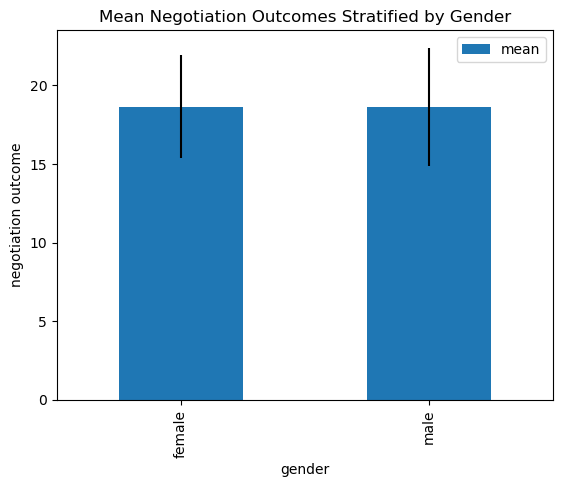

In [ ]:
df_meta_gp_gender = df_meta.groupby('gender')['outcome'].aggregate(['mean', 'std'])
df_meta_gp_gender.plot.bar(y='mean', yerr='std', 
                           title="Mean Negotiation Outcomes Stratified by Gender",
                           ylabel="negotiation outcome",
                           label="mean",
                          );

**Grading Instruction.** [3pt]
- [1 pt] has x- an y-axis labels and title
- [1 pt] has clear legend OR x-ticks (like plot above)
- [1 pt] has standard deviation around the mean

[B, 2pt] Perform a T-Test with a confidence interval of 0.95 to check if the outcomes based on gender are statistically significantly different. Print the resulting t-statistic, the p-value, and your interpretation of the result.

In [ ]:
from scipy.stats import ttest_ind

male_outcomes = df_document3_m[df_document3_m['gender'] == 'male']['outcome']
female_outcomes = df_document3_m[df_document3_m['gender'] == 'female']['outcome']

t_stat, p_value = ttest_ind(male_outcomes, female_outcomes, equal_var=False)

print(f"t_stat: {t_stat}\np_value: {p_value}\n")

if p_value < 0.05:
    print(f'>There IS a statistically significant difference in negotiation outcomes between genders')
else:
    print(f'>There is NOT a statistically significant difference in negotiation outcomes between genders')

t_stat: -0.15192015475218326
p_value: 0.8792650642656046

>There is NOT a statistically significant difference in negotiation outcomes between genders


**Grading Instruction.** [2pt]
- [1 pt] correct t_statistic and p_value
- [1 pt] correct interpretation

[C, 2pt] Finally, we would like to test if the gender distribution between high and low negotiation performers is significantly different. Please perform a chi-square test on the gender distribution of those negotiators scoring above the median outcome. Use a confidence interval of 0.95 and print the resulting chi-square statistic, p-value, and your interpretation of the result.

In [ ]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(
    df_document3_m['gender'],
    df_document3_m['success']
)

chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

print(f"chi2_stat: {chi2_stat}\np_value: {p_value}\n")

if p_value < 0.05:
    print(f'>There IS a statistically significant difference in gender distribution between high and low negotiation performers')
else:
    print(f'>There is NOT a statistically significant difference in gender distribution between high and low negotiation performers')

chi2_stat: 0.022622042552371116
p_value: 0.8804441039860444

>There is NOT a statistically significant difference in gender distribution between high and low negotiation performers


**Grading Instruction.** [2pt]
- [1 pt] correct chi2_stat and p_value
- [1 pt] correct interpretation

[D, 2pt] /Discuss:/ In addition to the gender attribute, could you think of other measurable factors in this dataset that could be tested as confounders? List at least two more and explain why.

**Grading Instruction.** [2pt]
- Age of negotiator/counter-negotiator
- Order, i.e., who starts the negotiation
- Average sentence length
- Other reasonable factors

for each correct factor 1pt up to 2pt in total. If more than 2 factors are give, subtract 1pt for each *incorrect* factor.

### Part 2: Insight Questions (15 pt)

**2.1 (3pt)**
In the context of analyzing negotiation turns, why would TF-IDF be more suitable than simple word frequency counts when trying to identify distinctive communication patterns between successful and unsuccessful negotiations?

**Grading Instruction**. [3 pt]

[3 pt] 
TF-IDF would be more suitable because it reduces the impact of commonly used words in negotiations (like "I", "agree", "think") while highlighting terms that are uniquely associated with specific negotiation outcomes. The IDF component helps identify words that are truly distinctive to successful or unsuccessful negotiations, rather than just counting frequent but uninformative terms. This allows for better identification of meaningful negotiation strategies and patterns.

**2.2 (2pt)**
How would you modify the standard TF-IDF implementation to account for the temporal nature of negotiation turns? Consider that early turns might be more important for setting the tone of the negotiation than later turns.

**Grading Instruction.** [2 pt]

A modified TF-IDF implementation could incorporate turn position weights by:

1. Multiplying the TF-IDF scores by a decay function based on turn position
2. Creating separate TF-IDF matrices for different phases of the negotiation (opening, middle, closing)
3. Using a weighted average where earlier turns receive higher weights in the final TF-IDF calculation
This would help capture the varying importance of terms based on when they appear in the negotiation sequence.
4. Another reasonable proposal

Full points if one of [1-4] is named. Partial point of up to 1pt.

**2.3 (3 pt)**
In our negotiation dataset, successful negotiators might simply write longer messages. How could this create a misleading interpretation of our TF-IDF results, and what would be a simple way to test for this potential bias?

**Grading instruction**. [3 pt]  
The TF-IDF scores could be artificially higher for successful negotiators simply because they write more, not because their word choices are more effective. To test this, we should calculate the correlation between message length and outcome_points, and potentially normalize our TF-IDF scores by document length if a strong correlation exists.

**2.4 (3pt)**
In our negotiation dataset, consider these two opening messages from different agents:

Agent A: "I propose we split the resources fairly" Agent B: "I suggest we divide the assets equitably"

These messages are semantically very similar but use different vocabulary. Explain:

- a) How TF-IDF would process these messages differently
- b) How word embeddings (like Word2Vec) would handle them
- c) Why this distinction matters for negotiation analysis

**Grading instruction**. [3 pt]

a) [1pt] TF-IDF would treat these messages as completely different because it uses bag-of-words representation.

b) [1 pt] Word embeddings would capture semantic similarity because: Words like "split"/"divide" and "fairly"/"equitably" would have similar vector representations due to their usage in similar contexts

c) [1 pt] One of:

Pro word embeddings: Negotiators often express the same strategy using different words. We want to identify negotiation patterns based on meaning, not just vocabulary. TF-IDF features could lead to classifying similar negotiation strategies as different, while word embeddings could capture these.

Pro TF-IDF: Although different negotiators might attempt the same semantic strategy, specific word choices could matter. Thus, word embeddings might miss the significance of vocabulary choices.

**2.5 (4pt)**
Staying in the context of negotiations, explain why N-gram models such as bigrams might be more informative than unigrams for predicting negotiation outcomes. Provide two examples of bigrams that would be particularly meaningful in negotiation contexts but would lose their significance if split into unigrams.

**Grading Instruction.** [4 pt]

[2 pt] for correct explanation:  
Bigrams capture phrase-level meaning that's lost in unigrams, particularly crucial for negotiations where intent and tone matter

[2 pt] for two correct examples. Examples could include:
- "strongly disagree" vs "strongly" and "disagree" separately
- "fair offer" vs "fair" and "offer" separately
- “absolutely not” vs. “absolutely” and “not” separately
- “completely understand” vs. “completely” and “understand” separately

## Task 2: Analysis of Co-Author Network (50 pts)


In this part, you will analyze a reserach publication dataset derived from 
[social influence analysis in large-scale networks](https://keg.cs.tsinghua.edu.cn/jietang/publications/KDD09-Tang-et-al-Social-Influence-Analysis.pdf) (the paper itself is irrelevant to this exam, don't waste time reading it).

The citation data is extracted from DBLP, ACM, MAG (Microsoft Academic Graph), and other sources. Each paper is associated with abstract, authors, year, venue, and title.

Dataset: [citation dataset](https://cn.aminer.org/citation)

Paper: [social influence analysis in large-scale networks](https://keg.cs.tsinghua.edu.cn/jietang/publications/KDD09-Tang-et-al-Social-Influence-Analysis.pdf)


### Download data from the web

```bash
# For MacOS
curl https://lfs.aminer.cn/lab-datasets/citation/citation-network1.zip -o citation-network1.zip
# For Linux
wget https://lfs.aminer.cn/lab-datasets/citation/citation-network1.zip
unzip citation-network1.zip
ls -l outputacm.txt
```

For windows we recommend using WSL (Windows Subsystem for Linux) with above commands 

You can also directly downloading the file from the browser at https://lfs.aminer.cn/lab-datasets/citation/citation-network1.zip



In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt

from helper import load_data_as_df


# Define the file path
file_path = "outputacm.txt"

# Load the data into a DataFrame
df = load_data_as_df(file_path)

# check if the index column is the same as the index 

print(f"Dataset loaded with {len(df)} entries.")
print(f"colums: {df.columns}")

Dataset loaded with 629814 entries.
colums: Index(['title', 'authors', 'year', 'venue', 'references', 'abstract'], dtype='object')


**3.1 (6 pts)**: Analyze Papers Published Per Year

**Objective:**  
Analyze and visualize publication trends to understand how the research field has evolved over time.

#### Instructions:
1. Group the data by the year of publication and count the number of papers for each year (2 pts).
2. Plot a bar chart showing the number of papers published per year from **1990 to 2010**. (2 pts)
3. Focus on the pattern between **1996 and 2004**:
   - **Discuss:** Describe any notable trends or changes in the number of publications during this period. (2 pts)
   - **Bonus:** Hypothesize potential reasons for the observed pattern.  (2 pts)
     *Hint: Consider events or trends related to the dataset's focus on computer science.* 


year
2007.0    38312
2008.0    45378
2009.0    42842
2010.0      380
2018.0        1
dtype: int64


<AxesSubplot: title={'center': 'Number of papers per year'}, xlabel='year'>

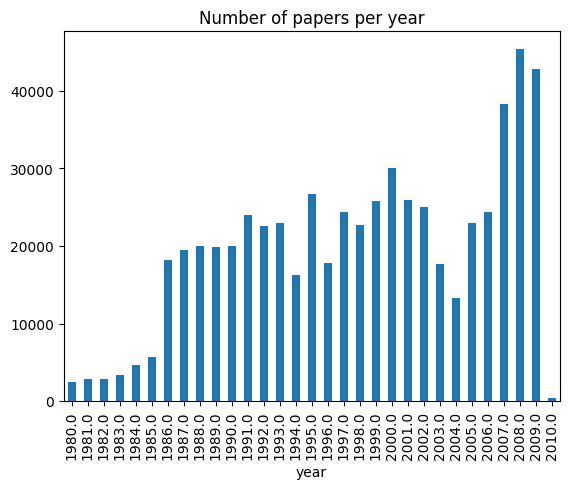

In [2]:
# Solution

def papers_per_year(data):
    return data.groupby("year").size()

year_distribution = papers_per_year(df)
print(year_distribution.tail())

# Plot the number of papers per year from 2000 to 2010
year_distribution.loc[1980:2010].plot(kind="bar", title="Number of papers per year")

# A reason might be the internet bubble in the late 90s which drove the interest in computer science research up and peaker in 2000 and then declined again.

**3.2 (4 pts)**: Authors Per Paper Analysis

With the rise of interdisciplinary research, multi-authored papers are becoming more common. This task will help us understand collaboration dynamics in the academic world.

#### Instructions:
- Get the number of authors for each paper and calculate the percentage of papers with four or more authors. (2 pts)
- Plot a histogram to show the frequency distribution of the number of authors per paper (2 pts)(choose `bins=range(0, 30)` and set y-axis to log scale).

In [3]:
# Solution

df["Author_Count"] = df["authors"].apply(lambda x: len(x))
print(f"Percentage of papers with 4 or more authors: {len(df[df['Author_Count'] >= 4]) / len(df) * 100:.2f}%")



Percentage of papers with 4 or more authors: 13.17%


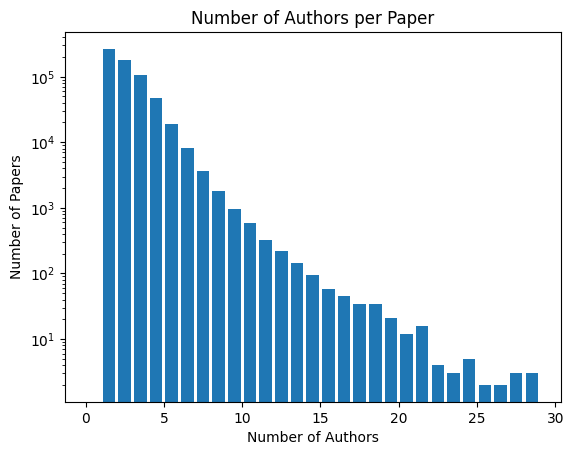

In [4]:
plt.hist(df["Author_Count"], bins=range(0, 30), rwidth=0.8)
plt.yscale("log")
plt.title("Number of Authors per Paper")
plt.xlabel("Number of Authors")
plt.ylabel("Number of Papers")
plt.show()

**3.3 (4 pts)**: Temporal Collaboration Trends

Collaboration dynamics can change over time. This task will help us understand how collaboration trends have evolved in the academic world.

#### Instructions:
- Group the data by publication year, calculate the average number of authors per paper for each year, and create a line plot to visualize how it has changed from 1990 to 2010 (1 pt).
- **Discuss:** There has been a hypothesis that the number of authors per paper has increased over time. Based on the plot, do you agree with this hypothesis ? (1 pt)
- Compute the P-value of the hypothesis that the average number of authors per paper after 2000 is significantly higher than before 2000. (2 pts)

<AxesSubplot: title={'center': 'Average number of authors per paper'}, xlabel='year'>

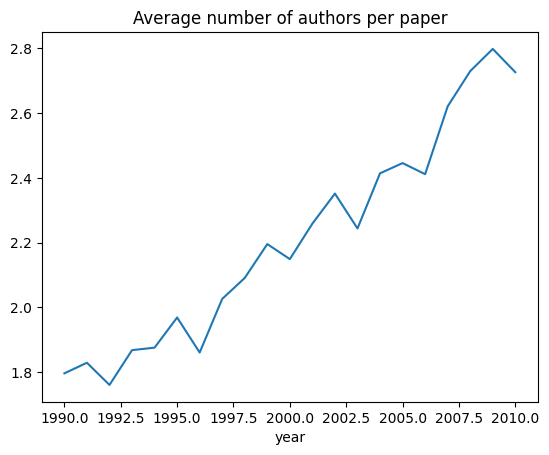

In [5]:

# Solution
def average_authors_per_paper(data):
    return data.groupby("year")["Author_Count"].mean()

average_authors = average_authors_per_paper(df)
average_authors.loc[1990:2010].plot(kind="line", title="Average number of authors per paper")

**Discuss:** Yes, the average number of authors per paper has steadily increased over time. This indicates that collaboration has increased over time.




In [6]:

before_2000 = df[df["year"] < 2000]["Author_Count"]
after_2000 = df[df["year"] >= 2000]["Author_Count"]

t_stat, p_value = sp.stats.ttest_ind(before_2000, after_2000)
print(f"P-value: {p_value:.2f}")

P-value: 0.00


**3.4 (6 pts)**: Build a Co-Author Network

Co-author networks help us visualize and quantify collaborations in academia. Such networks are critical for identifying influential researchers and their role in fostering connections within their communities. Construct a network where nodes represent authors and edges represent collaborations.

#### Instructions:
- Create a graph where: (5 pts)
  - Nodes: Each node represents a unique author, identified by their name in the authors field of the dataset.
  - Edges: There is an edge between two nodes if the corresponding authors have co-authored at least one paper. The weight of the edge represents the number of papers the two authors have co-authored together.
- After constructing the network, print the following information: (1 pt)
  - The total number of nodes (authors) in the network.
  - The total number of edges (collaborations) in the network.

Example:

For a paper authored by ["Alice", "Bob", "Charlie"], the graph should include:
- Nodes: Alice, Bob, Charlie.
- Edges: Alice-Bob, Alice-Charlie, Bob-Charlie, each with a weight of 1 (assuming no other collaborations between these pairs).


In [11]:
# Solution 1

def create_coauthor_network(data):
    G = nx.Graph()
    for author_list in data["authors"]:
        for i, author1 in enumerate(author_list):
            for author2 in author_list[i + 1:]:
                if G.has_edge(author1, author2):
                    G[author1][author2]["weight"] += 1
                else:
                    G.add_edge(author1, author2, weight=1)
    return G


G = create_coauthor_network(df)
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

Nodes: 505027, Edges: 1137185


In [12]:
# Solution 2
# One thing to note is that the above method doesn't take into account the single author papers.
# In the above method, all authors that have never did co-authorship are not included in the network.
# One may think it is better to include them in the network as well. The following code does that.

# clone the original graph to G2
G2 = G.copy()
nodes = df['authors'].values.tolist()
nodes = [x for xs in nodes for x in xs]
G2.add_nodes_from(nodes)
print(f"Nodes: {G2.number_of_nodes()}, Edges: {G2.number_of_edges()}")

Nodes: 595775, Edges: 1137185


In [ ]:
# We consider both the solutions as CORRECT, as it depends on whether we consider "single author papers" as "co-authorship" or not.

**3.5 (4 pts)**: Analyze the Co-Author Network

Connected components in a co-author network can reveal isolated research communities or dominant research hubs. Analyzing the largest component helps us understand the core of academic collaboration

#### Instructions:
- The degree of a node is the number of edges connected to it. In the context of the co-author network, this represents the number of distinct co-authors an author has collaborated with. Compute the average degree of the network (1 pt).
- Connectivity of the Network:
  - A network is fully connected if there is a path between every pair of nodes. Determine if the co-author network is fully connected (1 pt). (Hint: A single answer is not enough here. You need to use a method to verify the connectivity of the network.)
  - Can you tell how many authors are part of the largest connected component? How much does this account for the total number of authors in the network? (2 pt)
<!-- - Compute the average clustering coefficient of the network. -->

In [14]:
#  Compute the average degree of the network (1 pt).
average_degree = np.mean([d for n, d in G.degree()])
print(f"Average Degree: {average_degree:.2f}")

# For G2 (including single author papers)
average_degree = np.mean([d for n, d in G2.degree()])
print(f"Average Degree (including single author papers): {average_degree:.2f}")


Average Degree: 4.50
Average Degree (including single author papers): 3.82


In [10]:
# Determine if the co-author network is fully connected
is_connected = nx.is_connected(G)
print(f"Is the network fully connected: {is_connected}")

Is the network fully connected: False


In [ ]:
# get the author to node mapping
author2node_mapping = {author: i for i, author in enumerate(G.nodes())}
node2author_mapping = {i: author for author, i in author2node_mapping.items()}

In [11]:
# How many authors are part of the largest connected component?
components = nx.connected_components(G)
largest_component = max(components, key=len)
component_stats = {
    "largest_component_size": len(largest_component)
}

largest = component_stats["largest_component_size"]
print(f"Authors in the largest component: {largest}")

# Compute the percentage of authors in the largest component
total = len(G.nodes())
print(f"Percentage of authors in the largest component: {largest / total * 100:.2f}%")


Authors in the largest component: 342738
Percentage of authors in the largest component: 67.87%


In [15]:
# For G2 (including single author papers)
print("For G2(including single author papers):")
# How many authors are part of the largest connected component?
components = nx.connected_components(G2)
largest_component = max(components, key=len)
component_stats = {
    "largest_component_size": len(largest_component)
}

largest = component_stats["largest_component_size"]
print(f"Authors in the largest component: {largest}")

# Compute the percentage of authors in the largest component
total = len(G2.nodes())
print(f"Percentage of authors in the largest component: {largest / total * 100:.2f}%")


For G2(including single author papers):
Authors in the largest component: 342738
Percentage of authors in the largest component: 57.53%


**3.6 (4 pts)**: Top Authors by Collaborations

#### Instructions:
- Get the degree for all nodes in the network and print the top 10 authors by degree (1 pt) (Note: some entries (e.g., "II," "III," "Jr.") may not represent real authors due to data quality issues. Please keep them in the list and don't do any cleaning.)
- A high degree  indicates that an author has collaborated with many other authors. However, it does not consider if the collaborations happen multiple times between the same authors. A weighted degree would be a better measure to consider the number of collaborations between authors. Get the top 10 authors by weighted degree. P.S. The weighted degree is the sum of the weights of the edges connected to the node. (1 pt)
- Which two authors have the highest number of collaborations? How many papers have they co-authored together? (2 pt)

In [14]:
# top 10 authors by degree
top_degree_authors = sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]
print("Top 10 authors by degree:")
for node, centrality in top_degree_authors:
    print(f"{node}: {centrality}")



 Jr.: 6343
 III: 1340
 II: 785
Wei Wang: 316
Ming Li: 242
Wei Li: 228
Lei Zhang: 203
Elisa Bertino: 197
Hector Garcia-Molina: 193
Yan Zhang: 189


In [ ]:
# Compute the weighted degree centrality
weighted_degree_centrality = dict(G.degree(weight="weight"))

# Print the top 10 nodes by weighted degree centrality
top_weighted_degree = sorted(weighted_degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by weighted degree centrality:")
for node, centrality in top_weighted_degree:
    print(f"{node}: {centrality}")


Top 10 nodes by weighted degree centrality:
 Jr.: 9083
 III: 1836
 II: 1059
Philip S. Yu: 476
Wei Wang: 471
Elisa Bertino: 416
Ming Li: 382
Ron Kikinis: 359
Thomas J. Cashman: 338
Hector Garcia-Molina: 334


In [21]:
# - Which two authors have the highest number of collaborations? How many papers have they co-authored together?

# Solution
def top_collaborations(G):
    edge_weights = nx.get_edge_attributes(G, "weight")
    sorted_edges = sorted(edge_weights.items(), key=lambda x: x[1], reverse=True)
    return sorted_edges[:10]

colab = top_collaborations(G)
dict_colab = []
for (p1, p2), n in colab:
    dict_colab.append({"researcher_A": p1, "researcher_B": p2, "num_paper": n})

print(pd.DataFrame(dict_colab))

    

        researcher_A          researcher_B  num_paper
0     Gary B. Shelly     Thomas J. Cashman        156
1      Didier Dubois           Henri Prade         77
2     Irith Pomeranz     Sudhakar M. Reddy         73
3                Jr.                   Jr.         67
4  Divyakant Agrawal         Amr El Abbadi         67
5                Jr.      Paul F. Reynolds         51
6                Jr.         E. G. Coffman         49
7    Makoto Takizawa        Tomoya Enokido         47
8  Jock D. Mackinlay        Stuart K. Card         43
9                Jr.  Earl E. Swartzlander         40


**3.7 (4 pts)**: Analyze the reference/citation information 

Understanding the citation patterns of papers helps reveal their academic impact and how knowledge propagates through the research community. In this task, you will analyze the reference and citation relationships within the dataset.

First, let's create a citation network where:
- Nodes: Each node represents a unique paper, identified by its id in the dataset.
- Edges: There is an edge from paper A to paper B if paper A cites paper B. 


#### Instructions:
- **Discuss:** Is it reasonable that the citation network contains cycles?  What would a cycle( not self loop) in the citation network represent? (2 pt)
- Which paper has the highest number of citations? How many papers cite this paper? (1 pt)
- Which paper has the highest number of references? How many papers does this paper cite? (1 pt)


**Discuss:** No, it's technically not possible to have a cycle in a citation network. A citation is a temporal relationship where a paper published at time t1 can cite a paper published at time t2 where t2 < t1. Therefore, a cycle in a citation network would imply a paper citing a paper published after it which is not possible.

In [24]:
# Which paper has the highest number of citations? How many papers cite this paper?
df_with_references = df[df["references"].apply(lambda x: len(x) > 0)]
len(df_with_references)

# create a dictionary with the paper id as key and all the references as values
references_dict = dict(zip(df_with_references.index, df_with_references["references"]))

# create a directed graph from the references dictionary using networkx
G = nx.DiGraph(references_dict)


# compute the in-degree and out-degree of the graph and print the top 10 papers with the highest in-degree and out-degree respectively
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

sorted_in_degree = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)
sorted_out_degree = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)

print("Paper with highest in-degree(Citations):")
for paper_id, degree in sorted_in_degree[:1]:
    print(f"No.{paper_id}: {df.loc[paper_id]['title']}; it has {degree} citations")

print("\nPaper with highest out-degree(References):")
for paper_id, degree in sorted_out_degree[:1]:
    print(f"{paper_id}: {df.loc[paper_id]['title']}; it has {degree} references")
    


Paper with highest in-degree(Citations):
No.453387: Introduction to algorithms; it has 816 citations

Paper with highest out-degree(References):
216749: Query evaluation techniques for large databases; it has 195 references


**3.8 (3 pts)**: Analyze the Citation Distribution 

The citation distribution of papers can provide insights into the impact of research publications. In this task, you will analyze the citation distribution in the dataset.

<!-- - Plot the number of papers having a certain level of citation x (x-axis) against x (y-axis) in a log-log scale. -->
- Create a frequency distribution where the x-axis represents the number of citations and the y-axis represents the number of papers that have that number of citations. Plot two scatters plot of the frequency distribution first in a normal scale and second in a log-log scale. (2 pts)
- **Discuss**: What does the plot suggest about the citation distribution in the dataset? (1 pt)

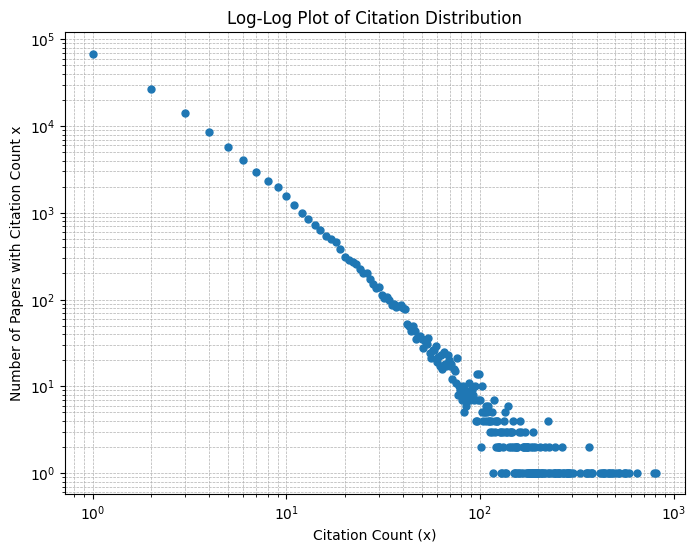

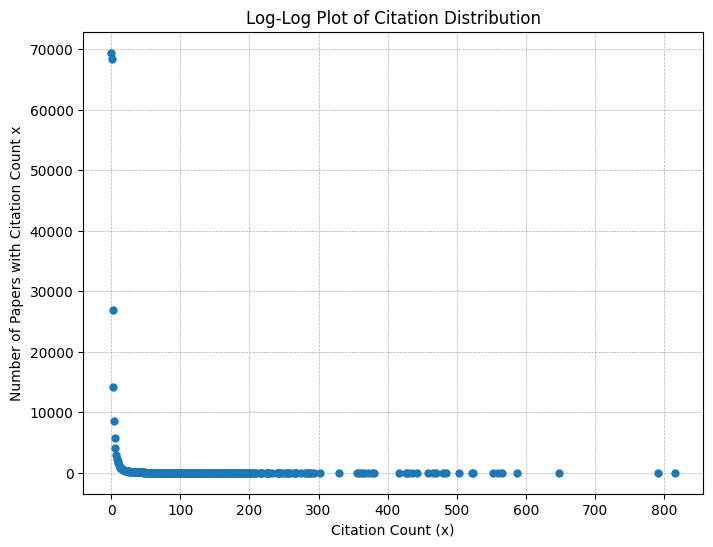

In [ ]:
# Plot the in-degree distribution
in_degree_values = list(in_degree.values())
in_degree_distribution = pd.Series(in_degree_values).value_counts().sort_index()


# Plotting in log-log scale
plt.figure(figsize=(8, 6))
plt.loglog(in_degree_distribution.index, in_degree_distribution, marker='o', linestyle='None', markersize=5)
plt.title("Log-Log Plot of Citation Distribution")
plt.xlabel("Citation Count (x)")
plt.ylabel("Number of Papers with Citation Count x")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# Plotting in log-log scale
plt.figure(figsize=(8, 6))
plt.plot(in_degree_distribution.index, in_degree_distribution, marker='o', linestyle='None', markersize=5)
plt.title("Log-Log Plot of Citation Distribution")
plt.xlabel("Citation Count (x)")
plt.ylabel("Number of Papers with Citation Count x")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()


**Discuss**: The plot suggests that the citation distribution follows a power-law distribution. A few papers have a high number of citations, while the majority have a low number of citations. This indicates that a small number of papers have a significant impact, while most papers have minimal impact in terms of citations.

**3.9 (3 pts)**: Central Tendency of Citation Distribution

**Discuss**: There are different ways to describe the typical value of the citation distribution, such as mean. Determine the measure you think best represents the dataset and explain your reasoning. (Hint: Consider the distribution of the citation data above)


Geometric mean is the best because the distribution is skewed and follows a power-law distribution. (This answer gives to 3 pts)

Median is the second best because it is less sensitive to outliers compared to the mean. (This leads to 2 pts)

**3.10 (2pts)**: Network Centrality Measures

PageRank, is a measure of influence based on link structure. Applying it to citations allows us to rank papers by their academic importance

#### Instructions:
- You are tasked with curating the 'Top 10 Influential Papers' from this dataset. Use PageRank to justify your selection and display the top 10 papers titles by page rank. (2 pts)
- **bonus**: Identify patterns among the top-ranked papers. (2 pts)


In [27]:

def compute_page_rank(G):
    page_rank = nx.pagerank(G)
    sorted_page_rank = sorted(page_rank.items(), key=lambda x: x[1], reverse=True)
    return sorted_page_rank[:10]

top_page_rank = compute_page_rank(G)

# find the paper title of the top 10 papers by page rank
top_page_rank_titles = [df.loc[paper_id]["title"] for paper_id, _ in top_page_rank]

print("Top 10 papers by page rank:")
print("\n".join(top_page_rank_titles))


Top 10 papers by page rank:
The art of computer programming, volume 1 (3rd ed.): fundamental algorithms
The art of computer programming, volume 2 (3rd ed.): seminumerical algorithms
A relational model of data for large shared data banks
A method for obtaining digital signatures and public-key cryptosystems
Introduction to algorithms
Simulation Modeling and Analysis, 2nd edition
Compilers: principles, techniques, and tools
C4.5: programs for machine learning
Smalltalk-80: the language and its implementation
The nature of statistical learning theory


**Discuss**: The top-ranked papers are mostly classical textbooks in Computer Science, including papers on Algorithm, Compiler, Database, and Machine Learning. (Other reasonable answers are also accepted)

**3.11 (5 pts)**: Bridge Papers

Bridge papers are those that connect different research communities. They are essential for fostering interdisciplinary research and knowledge transfer. 

#### Instructions: 
- Build a small citation network that only includes papers published in 2005. (2 pts)
- Which measurement can help us identify bridge papers in a citation network?  (2 pt)
- Try to find top10 bridge papers in the dataset. By looking at their titles, can you identify the research communities they connect? (Pick 2 papers) (1 pt)



In [29]:
#Build a small citation network that only includes papers published between 2000 and 2005.

sub_G = G.copy()
nodes_to_remove = [node for node in sub_G.nodes() if df.loc[node]["year"] != 2005]

sub_G.remove_nodes_from(nodes_to_remove)

print(f"Nodes: {sub_G.number_of_nodes()}, Edges: {sub_G.number_of_edges()}")


Nodes: 9370, Edges: 692


In [31]:
# Which measurement can help us identify bridge papers in a citation network?
# Answer：We can use betweenness centrality to identify bridge papers in a citation network. 


In [32]:
# find the paper title of the top 10 papers by betweenness centrality
def compute_betweenness_centrality(G):
    betweenness_centrality = nx.betweenness_centrality(G)
    sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)
    return sorted_betweenness[:10]

top_betweenness = compute_betweenness_centrality(sub_G)

top_betweenness_titles = [df.loc[paper_id]["title"] for paper_id, _ in top_betweenness]

print("\n".join(top_betweenness_titles))

The Globus Striped GridFTP Framework and Server
An integrated and adaptive decision-support framework for high-tech manufacturing and service networks
Detailed Exploration of Face-related Processing in Congenital Prosopagnosia: 1. Behavioral Findings
Using Discussion Prompts to Scaffold Parent-Child Collaboration Around a Computer-Based Activity
Efficient constraint processing for location-aware computing
Performance measures for service systems with a random arrival rate
Generation of problems, answers, grade, and feedback---case study of a fully automated tutor
A java library for simulating contact centers
Stability of persistence diagrams
Nonlinear operator integration factor splitting for the shallow water equations


**3.12 (5 pts)**: Author-Citation Network

In the previous tasks, we analyzed the co-author network and paper-citation network. In this task, we will analyze the author-citation network, where:
- Nodes: Each node represents a unique author, identified by their name in the authors field of the dataset.
- Edges: There is an edge from author A to author B if author A cites a paper authored by author B. 
- The weight of the edge represents the total number of citations from author A to author B.

#### Instructions:
- Given that we have a Author-Paper Matrix $A$ where each row represents an paper and each column represents an author. The value in the matrix is 1 if the author has contributed to the paper, 0 otherwise. And we also have a Paper-Paper citation matrix $P$ (square matrix) where the value at coordinates (i, j) is 1 if paper j cites paper i, 0 otherwise.
- How can you get a Author-Author citation matrix from the above two matrices by matrix multiplication? (You don't need to implement this, just give the formula) (2 pts)
- Author A may have never cited author B, but author A might have cited a few papers which cited works by author B. This can be seen as a 2nd degree citation.  More formally, a 2nd degree citation matrix $C_2$ has at each cell (i, j) the number 2nd degree citations from author i to author j. How can you get a 2nd degree citation matrix from the Author-Paper Matrix $A$ and Paper-Paper citation matrix $P$? (You don't need to implement this, just give the formula) (2 pts)
- Can you generalize this to nth degree citation matrix? (1 pt)

- $A^T P A $
- $A^T P^2 A $
- $A^T P^n A $